# Import functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


from sklearn.feature_selection import mutual_info_regression

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.append('../../nn_physical_concepts')

from scinet import *
import scinet.ed_oscillator as edo

import tqdm

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times'],'size' : 16})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

from sklearn.model_selection import train_test_split

# Load data

In [2]:
import pandas as pd

#extract generated data
df = pd.read_csv('../data/transient_data_ch41step.csv')

#extract forward rates
df_rates = pd.read_csv('../data/constant_data_ch41step.csv')
kf = np.zeros((1,2001))
for i in range(2001):
    kf[0,i] = float(df_rates['kf'][i][1:-1])
kf = kf[0]

# Helper functions

In [11]:
#converts data from pandas format to scinet format with 3 observations
def my_load_traindata_3(df,thalf = 1.25e-5):
    mydf = df[df['t [s]'] <=thalf]
    in1 = np.zeros((2001*25,25))
    in2 = np.zeros((2001*25,3))
    out = np.zeros((2001*25,1))
    for j in range(25):
        for i in range(1000,3001):
            in1[(i-1000)*25 + j,:] = mydf[mydf['T [K]']==i]['Yco2']
    in2[:,0] = mydf['t [s]']
    in2[:,1] = mydf['Yo2']
    in2[:,2] = mydf['Ych4']
    out[:,0] = mydf['Yco2']
    return [in1, in2, out]
#converts data from pandas format to scinet format with 3 observations at a specific T
def my_load_testdata3(df,T,thalf = 1.25e-5 ):
    mydf = df[df['t [s]'] <= thalf]
    in1 = np.zeros((51,25))
    in2 = np.zeros((51,3))
    for i in range(51): 
        in1[i,:] = mydf[mydf['T [K]']==T]['Yco2']
        in2[i,0] = i*5e-7
    in2[:,1] = df[df['T [K]']==T]['Yo2']
    in2[:,2] = df[df['T [K]']==T]['Ych4']
    out = np.zeros((51,1))
    return [in1,in2,out]

#randomizes and splits data to train test and dev sets
def my_train_test_split(train_data3,test_size = 0.25,random_state=42):
    in1train, in1tmp = train_test_split(train_data3[0], test_size=test_size, random_state=random_state)
    in2train, in2tmp = train_test_split(train_data3[1], test_size=test_size, random_state=random_state)
    outtrain, outtmp = train_test_split(train_data3[2], test_size=test_size, random_state=random_state)
    in1test, in1dev = train_test_split(in1tmp, test_size=0.5, random_state=random_state)
    in2test, in2dev = train_test_split(in2tmp, test_size=0.5, random_state=random_state)
    outtest, outdev = train_test_split(outtmp, test_size=0.5, random_state=random_state)
    return [in1train,in2train,outtrain],[in1test,in2test,outtest],[in1dev,in2dev,outdev]

#randomizes and splits temperature to train test and dev sets
def my_temp_train_test_split(test_size = 0.25,random_state=42):
    temp = np.arange(1000,3001)
    temptrain, temptmp = train_test_split(temp, test_size=test_size, random_state=random_state)
    temptest, tempdev = train_test_split(temptmp, test_size=0.5, random_state=random_state)
    return temptrain, temptest, tempdev


#converts data from pandas format to scinet format with 3 observations at a single T and time
def my_load_testdata_singletime(df,T,time,thalf = 1.25e-5 ):
    mydf = df[df['t [s]'] <= thalf]
    in1 = np.zeros((1,25))
    in2 = np.zeros((1,3))
    in1[0,:] = mydf[mydf['T [K]']==T]['Yco2']
    in2[0,0] = time
    in2[:,1] = df[(df['T [K]']==T) & (df['t [s]']<(time+4e-7))& (df['t [s]']>(time-4e-7))]['Yo2']
    in2[:,2] = df[(df['T [K]']==T) & (df['t [s]']<(time+4e-7))& (df['t [s]']>(time-4e-7))]['Ych4']
    out = np.zeros((1,1))
    return [in1,in2,out]







# Train and predict

In [4]:
#convert pandas to scinet input
train_data3  = my_load_traindata_3(df,thalf = 1.25e-5) 

In [13]:
#split data
td, vd, test_data  = my_train_test_split(train_data3) #randomise and split train and test sets

In [6]:
#initialize net
net = nn.Network(latent_size = 3,input_size =  25,input2_size = 3,output_size = 1,encoder_num_units= [500, 100],name = 'Prod1') #initialize net








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where









In [7]:
#initialize training

train_losses = []
dev_losses = []

#Training program
#procedure summary: 1000 epochs with alpha 1e-3, batch 512; 500 epochs with alpha 1e-4 batch 1024, 500 epochs with alpha 1e-5 batch 1024
num_phases = 3
all_epochs         = [100, 100,  100 ]
all_batches        = [32,  32, 32]
all_learning_rates = [1e-3, 1e-4, 1e-5]

myBeta = 1e-3

In [8]:
# Train
print_frequency = 0.1

for j in tqdm.tqdm_notebook(range(num_phases)):
    num_epochs = all_epochs[j]
    batch_size = all_batches[j]
    learning_rate = all_learning_rates[j]
    check_epochs = int(print_frequency * num_epochs)
    
    for i in tqdm.tqdm_notebook(range(num_epochs)):
        net.train(1, batch_size, learning_rate, td, vd, beta_fun=(lambda x: myBeta), test_step=10 )

        # Check progress. It is recommended to use Tensorboard instead for this.
        train_recon_error = net.run(td, net.recon_loss)
        train_kl_loss     = net.run(td, net.kl_loss)
        train_loss        = train_recon_error + myBeta*train_kl_loss

        dev_recon_error   = net.run(vd, net.recon_loss)
        dev_kl_loss       = net.run(vd, net.kl_loss)
        dev_loss          = dev_recon_error + myBeta*dev_kl_loss

        train_losses.append(train_loss)
        dev_losses.append(dev_loss)

        if i%check_epochs == 0:
            print("Training: (loss, reconstruction error, kl loss): ({:.2e}, {:.2e}, {:.2e})".format(
            train_loss, train_recon_error, train_kl_loss))
            print("Dev:      (loss, reconstruction error, kl loss): ({:.2e}, {:.2e}, {:.2e})".format(
            dev_loss, dev_recon_error, dev_kl_loss))
            print("=======================================")

    print("{} epochs trained so far".format(net.tot_epochs) )

/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/3 [00:00<?, ?it/s]

/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (6.13e-04, 5.60e-04, 5.33e-02)
Dev:      (loss, reconstruction error, kl loss): (6.11e-04, 5.58e-04, 5.38e-02)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (4.74e-06, 4.63e-06, 1.09e-04)
Dev:      (loss, reconstruction error, kl loss): (4.73e-06, 4.62e-06, 1.09e-04)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (2.07e-06, 2.01e-06, 6.20e-05)
Dev:      (loss, reconstruction error, kl loss): (2.11e-06, 2.04e-06, 6.19e-05)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (4.06e-06, 4.02e-06, 4.55e-05)
Dev:      (loss, reconstruction error, kl loss): (4.08e-06, 4.03e-06, 4.55e-05)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (9.73e-08, 9.73e-08, 0.00e+00)
Dev:      (loss, reconstruction error, kl loss): (1.01e-07, 1.01e-07, 0.00e+00)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (2.26e-07, 2.26e-07, 0.00e+00)
Dev:      (loss, reconstruction error, kl loss): (2.26e-07, 2.26e-07, 0.00e+00)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (2.77e-07, 2.75e-07, 1.49e-06)
Dev:      (loss, reconstruction error, kl loss): (2.75e-07, 2.73e-07, 1.50e-06)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (9.45e-09, 9.45e-09, -2.54e-10)
Dev:      (loss, reconstruction error, kl loss): (9.57e-09, 9.57e-09, -2.48e-10)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (2.88e-08, 2.88e-08, 0.00e+00)
Dev:      (loss, reconstruction error, kl loss): (2.93e-08, 2.93e-08, 0.00e+00)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (8.95e-09, 8.95e-09, 0.00e+00)
Dev:      (loss, reconstruction error, kl loss): (9.17e-09, 9.17e-09, 0.00e+00)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100 epochs trained so far


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (3.10e-09, 3.10e-09, -1.56e-10)
Dev:      (loss, reconstruction error, kl loss): (3.06e-09, 3.06e-09, -2.10e-10)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (4.42e-09, 4.42e-09, -2.13e-09)
Dev:      (loss, reconstruction error, kl loss): (4.28e-09, 4.28e-09, -1.89e-09)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (1.52e-09, 1.52e-09, 0.00e+00)
Dev:      (loss, reconstruction error, kl loss): (1.51e-09, 1.51e-09, 0.00e+00)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (1.17e-09, 1.17e-09, 0.00e+00)
Dev:      (loss, reconstruction error, kl loss): (1.15e-09, 1.15e-09, 0.00e+00)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (7.77e-09, 7.77e-09, 0.00e+00)
Dev:      (loss, reconstruction error, kl loss): (7.90e-09, 7.90e-09, 0.00e+00)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (4.99e-10, 4.99e-10, 0.00e+00)
Dev:      (loss, reconstruction error, kl loss): (4.96e-10, 4.96e-10, 0.00e+00)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (1.51e-09, 1.51e-09, 0.00e+00)
Dev:      (loss, reconstruction error, kl loss): (1.53e-09, 1.53e-09, 0.00e+00)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (8.26e-10, 8.26e-10, 0.00e+00)
Dev:      (loss, reconstruction error, kl loss): (8.27e-10, 8.27e-10, 0.00e+00)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (2.61e-10, 2.61e-10, 0.00e+00)
Dev:      (loss, reconstruction error, kl loss): (2.61e-10, 2.61e-10, 0.00e+00)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (9.18e-10, 9.19e-10, -7.82e-10)
Dev:      (loss, reconstruction error, kl loss): (9.25e-10, 9.26e-10, -8.01e-10)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

200 epochs trained so far


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (1.17e-10, 1.18e-10, -6.13e-10)
Dev:      (loss, reconstruction error, kl loss): (1.15e-10, 1.15e-10, -6.10e-10)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (7.36e-11, 7.38e-11, -1.72e-10)
Dev:      (loss, reconstruction error, kl loss): (7.15e-11, 7.16e-11, -1.53e-10)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (6.88e-11, 6.97e-11, -8.80e-10)
Dev:      (loss, reconstruction error, kl loss): (6.65e-11, 6.74e-11, -9.34e-10)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (7.61e-11, 7.64e-11, -3.43e-10)
Dev:      (loss, reconstruction error, kl loss): (7.35e-11, 7.39e-11, -4.00e-10)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (6.60e-11, 6.66e-11, -6.01e-10)
Dev:      (loss, reconstruction error, kl loss): (6.39e-11, 6.45e-11, -5.15e-10)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (6.90e-11, 6.92e-11, -2.22e-10)
Dev:      (loss, reconstruction error, kl loss): (6.86e-11, 6.89e-11, -2.10e-10)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (6.15e-11, 6.16e-11, -5.40e-11)
Dev:      (loss, reconstruction error, kl loss): (6.11e-11, 6.12e-11, -5.72e-11)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (1.43e-10, 1.43e-10, -1.18e-10)
Dev:      (loss, reconstruction error, kl loss): (1.44e-10, 1.44e-10, -1.91e-10)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (4.01e-11, 4.02e-11, -5.72e-11)
Dev:      (loss, reconstruction error, kl loss): (3.92e-11, 3.93e-11, -3.81e-11)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training: (loss, reconstruction error, kl loss): (7.18e-11, 7.18e-11, 0.00e+00)
Dev:      (loss, reconstruction error, kl loss): (7.01e-11, 7.01e-11, 0.00e+00)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

300 epochs trained so far


# Postprocess Results

Text(0.5,0,'\\# Epochs')

/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


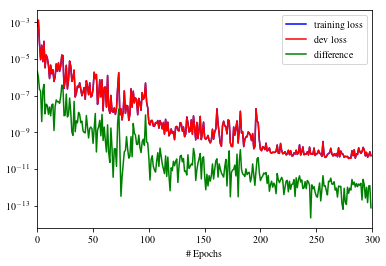

In [9]:
#Loss vs Epoch

plt.semilogy(range(300),train_losses,'b',label='training loss')
plt.semilogy(range(300),dev_losses,'r',label='dev loss')
plt.semilogy(range(300),abs(np.array(train_losses)-np.array(dev_losses)),'g',label='difference')
plt.legend()
plt.xlim(0,300)
plt.xlabel(r'\# Epochs')

Text(0.5,0,'Time [$\\mu$s]')

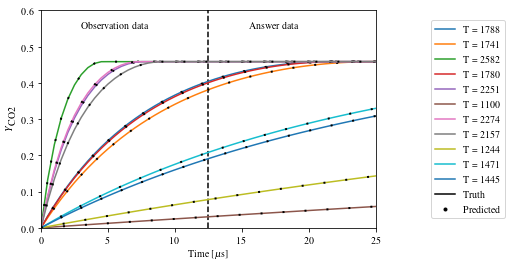

In [12]:
#Predictions for test set
t = np.arange(51)*5e-1 #mus
T = 1000
plt.plot([12.5,12.5],[0,0.6],'k--')

tT, vt, Ttest  = my_temp_train_test_split()

for T in Ttest[::25]: 
    test_data = my_load_testdata3(df,T)
    a_precicted = net.run(test_data, net.output).ravel()
    plt.plot(t,a_precicted,label = r'T = '+str(T))

    plt.plot(t,df[df['T [K]']==T]['Yco2'],'k--', dashes= (1,10),label='_nolegend_',linewidth = 2)

plt.plot([-1],[-1],'k',label ='Truth')

plt.plot(-1,-1,'k.',label='Predicted')

plt.legend(loc='center right',bbox_to_anchor = (1.4,0.5))
plt.xlim((0,25))
plt.ylim((0,0.6))
plt.text(3,0.55,'Observation data')
plt.text(15.5,0.55,'Answer data')
plt.ylabel(r'$Y_{\textrm{CO2}}$')
plt.xlabel(r'Time [$\mu$s]')

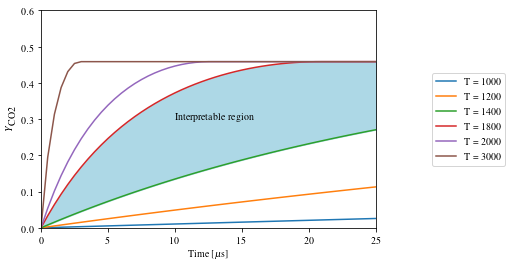

In [14]:
#Interpretable temperatures

t = np.arange(51)*5e-1 #mus
T = 1000

Ttest = [1000,1200,1400,1800,2000,3000]

for T in Ttest: 
    test_data = my_load_testdata3(df,T)
    a_precicted = net.run(test_data, net.output).ravel()
    plt.plot(t,a_precicted,label = r'T = '+str(T))
    
plt.fill_between(t, df[df['T [K]']==1400]['Yco2'],  df[df['T [K]']==1800]['Yco2'],color='lightblue')
plt.text(10,0.3,'Interpretable region')
plt.legend(loc='center right',bbox_to_anchor = (1.4,0.5))
plt.xlim((0,25))
plt.ylim((0,0.6))
plt.ylabel(r'$Y_{\textrm{CO2}}$')
plt.xlabel(r'Time [$\mu$s]')
plt.savefig('chem_interp_co2.png',dpi=400,bbox_inches='tight')

In [16]:
#evaluate latent space
latentspace = np.zeros((101,3))
time = 1.5e-5
for T in range(1000,3001,20):
    latentspace[(T-1000)/20,:] = np.array([net.run(my_load_testdata_singletime(df,T,time), net.mu)[0] ])

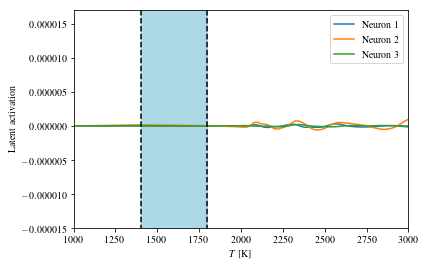

In [17]:
#Interpretable latent space


plt.fill_between([1400,1800],[-15e-6,-15e-6],[17e-6,17e-6],color='lightblue')

plt.plot(range(1000,3001,20),latentspace[:,0],label = 'Neuron 1')
plt.plot(range(1000,3001,20),latentspace[:,1],label ='Neuron 2')
plt.plot(range(1000,3001,20),latentspace[:,2],label ='Neuron 3')

plt.ylabel('Latent activation')
plt.plot([1400,1400],[17e-6,-15e-6],'k--')
plt.plot([1800,1800],[17e-6,-15e-6],'k--')
plt.ylim([-15e-6,17e-6])
plt.legend()

plt.xlabel(r'$T$ [K]')
plt.xlim([1000,3000])
# plt.xticks([0,5e5,1e6,1.5e6,2e6])
plt.savefig('chem_interp_latent.png',dpi=400,bbox_inches='tight')

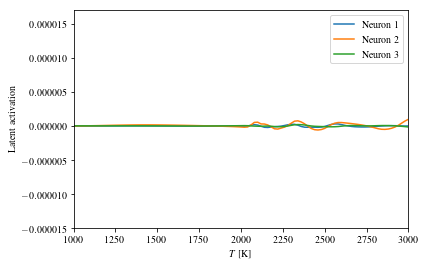

In [20]:
#latent space vs T

plt.plot(range(1000,3001,20),latentspace[:,0],label = 'Neuron 1')
plt.plot(range(1000,3001,20),latentspace[:,1],label ='Neuron 2')
plt.plot(range(1000,3001,20),latentspace[:,2],label ='Neuron 3')

plt.ylabel('Latent activation')

plt.ylim([-15e-6,17e-6])
plt.legend()

plt.xlabel(r'$T$ [K]')
plt.xlim([1000,3000])
# plt.xticks([0,5e5,1e6,1.5e6,2e6])
plt.savefig('chem_interp_latent.png',dpi=400,bbox_inches='tight')

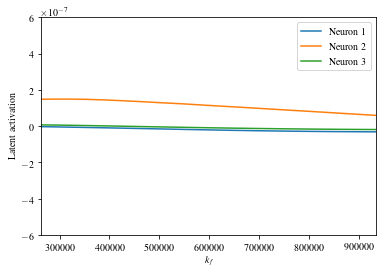

In [19]:
#latent space vs kf

plt.plot(kf[0:2001:20],latentspace[:,0],label = 'Neuron 1')
plt.plot(kf[0:2001:20],latentspace[:,1],label ='Neuron 2')
plt.plot(kf[0:2001:20],latentspace[:,2],label = 'Neuron 3')
plt.ylabel('Latent activation')
plt.legend()
plt.xlabel(r'$k_f$')
plt.xlim([kf[400],kf[700]])
plt.ylim([-6e-7,6e-7])
plt.savefig('chem_latent.png',dpi=400,bbox_inches='tight')